# Do most "novel" exons only differ by a few base pairs?

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import defaultdict
from matplotlib import font_manager
import numpy as np
import csv
import pickle
import ast

/users/jferrer/jmidgley/annotation_project/lib64/python3.9/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
combined_df = pd.read_csv( '../data_processed/curated_HIT.tsv', sep='\t', dtype=str)

In [3]:
# Load partially unannotated exons
with open("../data_processed/partially_unannotated_df.pkl", "rb") as f:
    partially_unannotated_df = pickle.load(f)

In [4]:
partially_unannotated_df.head()

,Chromosome,Start,End,transcript_id,Strand,is_overlapping
0,chr1,938827,938950,ENCT00000000083.1,+,False
1,chr1,943908,944267,ENCT00000000083.1,+,True
2,chr1,1435716,1435830,ENCT00000000299.1,+,True
3,chr1,1445128,1447225,ENCT00000000299.1,+,False
4,chr1,1505693,1505736,ENCT00000000337.1,+,True


In [5]:
# Get transcripts with only overlapping novel exons
non_overlapping_ids = set(
    partially_unannotated_df.loc[partially_unannotated_df["is_overlapping"] == False, "transcript_id"]
)
overlapping_ids = set(partially_unannotated_df["transcript_id"]) - non_overlapping_ids

In [6]:
len(overlapping_ids)

193904

In [7]:
# Extract these transcripts from combined_df
tx_with_overlap = combined_df[combined_df["transcript_id"].isin(overlapping_ids)].iloc[:,:7]
tx_with_overlap["unannotated_exons"] = tx_with_overlap["unannotated_exons"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [8]:
tx_with_overlap

,transcript_id,chr,exons,matched_to,category,unannotated_exons,Strand
128692,ENCT00000000337.1,chr1,"[(1505693, 1505736), (1509205, 1509467)]",NaN,Transcripts with annotated exons and only over...,"[(1505693, 1505736)]",+
128693,ENCT00000000501.1,chr1,"[(2555971, 2556733), (2557726, 2557834), (2558...",NaN,Transcripts with annotated exons and only over...,"[(2555971, 2556733), (2558881, 2559978), (2563...",+
128694,ENCT00000000552.1,chr1,"[(3454665, 3454811), (3463066, 3463672), (3466...",NaN,Transcripts with annotated exons and only over...,"[(3487196, 3487342)]",+
128695,ENCT00000000579.1,chr1,"[(3625034, 3625053), (3625424, 3625515), (3625...",NaN,Transcripts with annotated exons and only over...,"[(3625034, 3625053)]",+
128696,ENCT00000000582.1,chr1,"[(3625034, 3625106), (3625713, 3625889), (3627...",NaN,Transcripts with annotated exons and only over...,"[(3625034, 3625106)]",+
...,...,...,...,...,...,...,...
322591,STRT02296511,chrY,"[(19567850, 19567951), (19587210, 19597665), (...",NaN,Transcripts with annotated exons and only over...,"[(19587210, 19597665), (19603797, 19605812)]",+
322592,STRT02296664,chrY,"[(19567342, 19567570), (19587210, 19587507), (...",NaN,Transcripts with annotated exons and only over...,"[(19590083, 19591959), (19594758, 19597665), (...",+
322593,STRT02296673,chrY,"[(13231167, 13234826), (13251017, 13251187), (...",NaN,Transcripts with annotated exons and only over...,"[(13231167, 13234826), (13357877, 13358619)]",-
322594,STRT02296676,chrY,"[(13303685, 13306250), (13323555, 13323760), (...",NaN,Transcripts with annotated exons and only over...,"[(13303685, 13306250), (13357877, 13358553)]",-


In [9]:
# Load GENCODE exons
gencode_v47_df = pd.read_csv("../data_raw/gencode.v47.tsv", sep="\t", dtype=str)
gencode_v47_df

,seqname,source,feature,start,end,score,strand,frame,gene_id,transcript_id,...,exon_id,level,tag,transcript_support_level,havana_transcript,hgnc_id,ont,havana_gene,protein_id,ccdsid
0,chr1,HAVANA,exon,11121,11211,.,+,.,ENSG00000290825.2,ENST00000832824.1,...,ENSE00004248723.1,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,exon,12010,12227,.,+,.,ENSG00000290825.2,ENST00000832824.1,...,ENSE00004248735.1,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,12613,12721,.,+,.,ENSG00000290825.2,ENST00000832824.1,...,ENSE00003582793.1,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,exon,13453,14413,.,+,.,ENSG00000290825.2,ENST00000832824.1,...,ENSE00004248730.1,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,HAVANA,exon,11125,11211,.,+,.,ENSG00000290825.2,ENST00000832825.1,...,ENSE00004248721.1,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155000,chrM,ENSEMBL,exon,14149,14673,.,-,.,ENSG00000198695.2,ENST00000361681.2,...,ENSE00001434974.2,3,appris_principal_1,NaN,NaN,HGNC:7462,NaN,NaN,ENSP00000354665.2,NaN
2155001,chrM,ENSEMBL,exon,14674,14742,.,-,.,ENSG00000210194.1,ENST00000387459.1,...,ENSE00001544476.1,3,Ensembl_canonical,NaN,NaN,HGNC:7479,NaN,NaN,NaN,NaN
2155002,chrM,ENSEMBL,exon,14747,15887,.,+,.,ENSG00000198727.2,ENST00000361789.2,...,ENSE00001436074.2,3,appris_principal_1,NaN,NaN,HGNC:7427,NaN,NaN,ENSP00000354554.2,NaN
2155003,chrM,ENSEMBL,exon,15888,15953,.,+,.,ENSG00000210195.2,ENST00000387460.2,...,ENSE00001544475.2,3,Ensembl_canonical,NaN,NaN,HGNC:7499,NaN,NaN,NaN,NaN


In [10]:
# Extract only the novel exons from these tx
tx_with_overlap_exons = tx_with_overlap.explode("unannotated_exons").reset_index(drop=True)

In [11]:
# Get start and end positions for each exon
tx_with_overlap_exons["Start"] = tx_with_overlap_exons["unannotated_exons"].apply(lambda x: x[0])
tx_with_overlap_exons["End"] = tx_with_overlap_exons["unannotated_exons"].apply(lambda x: x[1])

In [12]:
# Kee relevant query columns
query_exons = tx_with_overlap_exons[["chr", "Start", "End", "transcript_id"]].rename(
    columns={"chr": "Chromosome"}
)

In [13]:
# Rename and keep relevant reference columns
ref_exons = gencode_v47_df.rename(
    columns={"seqname": "Chromosome", "start": "Start", "end": "End"}
)
ref_exons = ref_exons[["Chromosome", "Start", "End", "transcript_id"]]


In [14]:
# Convert to pyranges
query_pr = pr.PyRanges(query_exons)
ref_pr = pr.PyRanges(ref_exons)

In [15]:
# Compute overlaps
overlaps = query_pr.join(ref_pr, suffix="_ref")

overlaps_df = overlaps.as_df()

In [16]:
# Compute differences between start and end positions
overlaps_df["start_diff"] = abs(overlaps_df["Start"] - overlaps_df["Start_ref"])
overlaps_df["end_diff"]   = abs(overlaps_df["End"]   - overlaps_df["End_ref"])

# max distance from either side
overlaps_df["max_diff"] = overlaps_df[["start_diff", "end_diff"]].abs().max(axis=1)

In [17]:
overlaps_df.sort_values(by="max_diff", ascending=False)

,Chromosome,Start,End,transcript_id,Start_ref,End_ref,transcript_id_ref,start_diff,end_diff,max_diff
2308797,chr17,37988775,38195940,MICT00000146405.1,38195872,38195940,ENST00000620148.2,207097,0,207097
2424226,chr17,37988837,38195940,STRT00944431,38195872,38195940,ENST00000620148.2,207035,0,207035
2423222,chr17,37988873,38195940,STRT00944070,38195872,38195940,ENST00000620148.2,206999,0,206999
2443695,chr17,37988891,38195940,STRT00957717,38195872,38195940,ENST00000620148.2,206981,0,206981
2308796,chr17,37988775,38195940,MICT00000146405.1,38195753,38195940,ENST00000701223.1,206978,0,206978
...,...,...,...,...,...,...,...,...,...,...
684024,chr3,177064920,177065021,STRT01546976,177064920,177065022,ENST00000627825.2,0,1,1
684025,chr3,177064920,177065021,STRT01546976,177064920,177065022,ENST00000427349.5,0,1,1
684026,chr3,177064920,177065021,STRT01546976,177064920,177065022,ENST00000413084.5,0,1,1
1326517,chr8,71244604,71244692,STRT02088220,71244603,71244692,ENST00000465115.6,1,0,1


In [18]:
# For each exon, keep only the one with largest overlap (smallest start/end diff)
idx = overlaps_df.groupby(["Chromosome", "Start", "End", "transcript_id"], observed=True)["max_diff"].idxmin()

best_overlaps = overlaps_df.loc[idx].reset_index(drop=True)

In [19]:
best_overlaps.sort_values(by="max_diff", ascending=False)

,Chromosome,Start,End,transcript_id,Start_ref,End_ref,transcript_id_ref,start_diff,end_diff,max_diff
279289,chrX,139069478,139204271,STRT02268545,139203416,139203525,ENST00000421460.1,133938,746,133938
186998,chr3,53517241,53650918,STRT01553755,53530322,53530401,ENST00000516178.1,13081,120517,120517
246407,chr7,111282011,111417342,STRT01937555,111390571,111390750,ENST00000489381.1,108560,26592,108560
246408,chr7,111284061,111417342,STRT01978303,111390571,111390750,ENST00000489381.1,106510,26592,106510
112122,chr17,37989745,38195940,STRT00893943,38089399,38089500,ENST00000614282.1,99654,106440,106440
...,...,...,...,...,...,...,...,...,...,...
258266,chr8,130091973,130092142,STRT02113950,130091973,130092143,ENST00000524124.5,0,1,1
20245,chr1,160999640,160999748,PBT00040967,160999640,160999747,ENST00000368026.11,0,1,1
194641,chr3,175466979,175467185,FTMT21100060844.1,175466979,175467184,ENST00000454872.6,0,1,1
176140,chr22,29367207,29367271,ENST00000402502.1,29367207,29367270,ENST00000357586.7,0,1,1


In [20]:
best_overlaps["transcript_id"].nunique()

193904

In [21]:
# nr of exons
best_overlaps[["Chromosome", "Start", "End", "transcript_id"]].drop_duplicates().shape[0]

280850

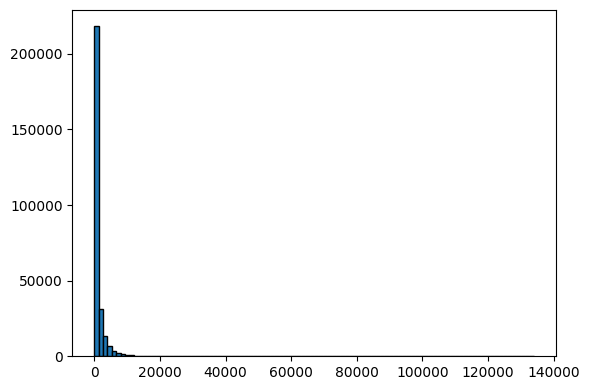

In [22]:
plt.figure(figsize=(6,4))
plt.hist(best_overlaps["max_diff"], bins=100, edgecolor="black")
plt.tight_layout()
plt.show()

In [26]:
# How many tx have an exon that differs by no more than 100 tx?
best_overlaps[best_overlaps["max_diff"] <= 100]["transcript_id"].nunique()

48555

In [25]:
# How many tx have an exon that differs by no more than 100 tx?
best_overlaps[best_overlaps["max_diff"] <= 10]["transcript_id"].nunique()

14815

In [94]:
# Percent of transcripts that contain a "novel" exon which differs to GENCODE by no more than 10 bases
14815/193904 *100

7.6403787441208015